In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import tensorflow as tf
import tfgraphviz as tfg

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ReluNet_Sequential():
    def __init__(self, hidden_num = 1, batch_size = 100, training_epochs = 1000, learning_rate= 0.01):
        # Parameter initiation
        self.hidden_num = hidden_num
        self.batch_size = batch_size
        self.training_epochs = training_epochs
        self.learning_rate= learning_rate
        # clear previous graph
        tf.reset_default_graph()
        # Network Defination
        self.X = tf.placeholder("float")
        self.Y = tf.placeholder("float")
        self.training_layer = 0
        self.hidden_num = hidden_num
        self.create_relu_net()

    def create_relu_net(self):
        # hidden layer        
        self.W = []; self.b = []; 
        self.h = []; self.h.append(self.X)       
        self.output_list = [] 
        self.cost_list = [] 
        self.train_op_list = []
        subnet_arch = list(np.hstack([np.array(1), np.array(self.hidden_num)]))
        
        with tf.variable_scope("Hierachical_ReluNet", reuse=tf.AUTO_REUSE):
            self.W.append(tf.get_variable("L1_W", initializer= \
                                          np.ones((subnet_arch[0], subnet_arch[1]), dtype = np.float32), trainable = False))
            self.b.append(tf.get_variable("L1_b", initializer= \
                                          -np.linspace(0, 1, self.hidden_num[0], dtype = np.float32)))
            self.h.append(tf.nn.relu(tf.matmul(self.h[0], self.W[0]) + self.b[0]))

            self.WOut = tf.get_variable(name = "L1_Wout", initializer = tf.random_normal([subnet_arch[1], 1], 0, 0.01))
            self.bOut = tf.get_variable(name = "L1_bout", initializer = tf.constant(0.0, shape=[1]))
            self.output_list.append(tf.matmul(self.h[-1], self.WOut) + self.bOut)    
            self.cost_list.append(tf.reduce_mean(tf.square(self.Y - self.output_list[-1])))
            self.train_op_list.append(tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost_list[-1], \
                                     var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Hierachical_ReluNet/L"+str(1))))
            for i in range(len(subnet_arch)-2):
                self.W.append(tf.get_variable("L"+str(i+2)+"_W", initializer= \
                                 tf.random_normal([subnet_arch[i+1], subnet_arch[i+2]], mean=0.0, stddev=0.1)))
                self.b.append(tf.get_variable("L"+str(i+2)+"_b", initializer= \
                                 tf.random_normal([subnet_arch[i+2]], mean=0.0, stddev=0.001)))
                self.h.append(tf.matmul(self.h[-1], self.W[-1]) + self.b[-1])

                self.WOut = tf.get_variable("L"+str(i+2)+"_Wout", initializer= \
                                         tf.random_normal([subnet_arch[i+2], 1], mean=0.0, stddev=0.1))
                self.bOut = tf.get_variable(name = "L"+str(i+2)+"_bout", initializer = tf.constant(0.0, shape=[1]))
                self.output_list.append(tf.matmul(self.h[-1], self.WOut) + self.bOut)

                self.cost_list.append(tf.reduce_mean(tf.square(self.Y - self.output_list[-1])))
                self.train_op_list.append(tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost_list[-1], \
                                     var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Hierachical_ReluNet/L"+str(i+2))))               

        # initilize
        self.sess = tf.Session()
        self.init_op = tf.group(
                tf.local_variables_initializer(),
                tf.global_variables_initializer()
                )
        self.sess.run(self.init_op)

    def train(self, train_x, train_y, training_layer = 0):
        self.err_train = []
        self.training_layer = training_layer
        train_size = train_x.shape[0]
        training_data = np.hstack([train_x,train_y])
        mini_batches = [training_data[k:k+self.batch_size] for k in range(0, train_size, self.batch_size)]
        for epoch in range(self.training_epochs):
            for i in range(len(mini_batches)):
                self.sess.run(self.train_op_list[self.training_layer], feed_dict={self.X: mini_batches[i][:,:1], self.Y: mini_batches[i][:,1:]})
            if (epoch + 1) % 500 == 0:
                err_train = self.sess.run(self.cost_list[self.training_layer], feed_dict={self.X: train_x, self.Y: train_y})
                self.err_train.append(err_train)
                print("Epoch ", epoch + 1, " Loss:", err_train)
        pred_train = self.sess.run(self.output_list[self.training_layer], feed_dict={self.X: train_x, self.Y: train_y})
        return pred_train 
        
    def predict(self, test_x):
        for i in range(self.hidden_layer):
            print("The " + str(i+1) +" Layer:",np.round(self.sess.run(self.hs[i], feed_dict={self.X: test_x}),3))
        pred = self.sess.run([self.output_list[self.training_layer]], feed_dict={self.X: test_x})
        print("The Final Output:",pred)
        return pred

# Test Example: Doppler Curve

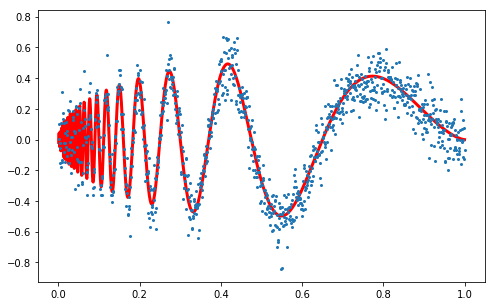

In [3]:
def doppler(DataNum, noise_level):
    x = np.linspace(1, DataNum, DataNum)/DataNum
    y0 = np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+0.05)) 
    y = y0 + noise_level*np.random.normal(0, 1, DataNum)
    return x, y0, y

DataNum = 1024
x, y0, y = doppler(DataNum, 0.1)
scaler = MinMaxScaler()
train_x = np.reshape(np.linspace(1, DataNum, DataNum)/DataNum, [-1,1])
train_y = scaler.fit_transform(y.reshape([-1,1]))

plt.figure(1, figsize=(8, 5))
plt.plot(x, y0, color="red", LineWidth=3)
plt.plot(x, y, 'o', MarkerSize=2)
plt.show()

In [4]:
nnpar = [50, 20, 10]
model = ReluNet_Sequential(hidden_num = nnpar, batch_size = 1024, training_epochs = 5000, learning_rate= 0.01)

## Traing the first layer

Epoch  500  Loss: 0.02197706
Epoch  1000  Loss: 0.018967705
Epoch  1500  Loss: 0.017117597
Epoch  2000  Loss: 0.015775159
Epoch  2500  Loss: 0.015057981
Epoch  3000  Loss: 0.01428437
Epoch  3500  Loss: 0.013958981
Epoch  4000  Loss: 0.0142014995
Epoch  4500  Loss: 0.0135061005
Epoch  5000  Loss: 0.013203753


Text(0.5,1,'ReLU Structure: [50, 20, 10] Layer 1 Trained')

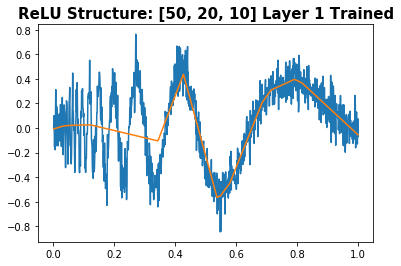

In [5]:
pred_train = model.train(train_x, train_y, 0)
plt.plot(train_x,scaler.inverse_transform(train_y))
plt.plot(train_x,scaler.inverse_transform(pred_train))
plt.title('ReLU Structure: ' + str(nnpar) + " Layer 1 Trained", fontsize=15, fontweight="bold")

## Traing the second layer

Epoch  500  Loss: 0.014939399
Epoch  1000  Loss: 0.0132811135
Epoch  1500  Loss: 0.013056681
Epoch  2000  Loss: 0.013947003
Epoch  2500  Loss: 0.012952061
Epoch  3000  Loss: 0.013242734
Epoch  3500  Loss: 0.0130766
Epoch  4000  Loss: 0.012929434
Epoch  4500  Loss: 0.0129272975
Epoch  5000  Loss: 0.012957688


Text(0.5,1,'ReLU Structure: [50, 20, 10] Layer 2 Trained')

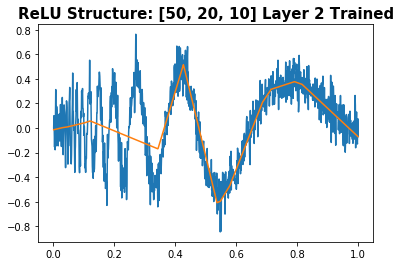

In [6]:
pred_train = model.train(train_x, train_y, 1)
plt.plot(train_x,scaler.inverse_transform(train_y))
plt.plot(train_x,scaler.inverse_transform(pred_train))
plt.title('ReLU Structure: ' + str(nnpar) + " Layer 2 Trained", fontsize=15, fontweight="bold")

## Traing the third layer

Epoch  500  Loss: 0.012923014
Epoch  1000  Loss: 0.0129192835
Epoch  1500  Loss: 0.012917049
Epoch  2000  Loss: 0.012915575
Epoch  2500  Loss: 0.012914082
Epoch  3000  Loss: 0.0129123945
Epoch  3500  Loss: 0.0129107265
Epoch  4000  Loss: 0.012910007
Epoch  4500  Loss: 0.012907541
Epoch  5000  Loss: 0.012906199


Text(0.5,1,'ReLU Structure: [50, 20, 10] Layer 3 Trained')

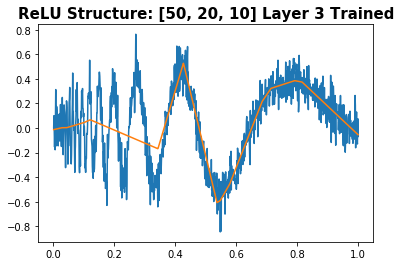

In [7]:
pred_train = model.train(train_x, train_y, 2)
plt.plot(train_x,scaler.inverse_transform(train_y))
plt.plot(train_x,scaler.inverse_transform(pred_train))
plt.title('ReLU Structure: ' + str(nnpar) + " Layer 3 Trained", fontsize=15, fontweight="bold")

Text(0.5,1,'ReLU Ridges in Layer 3')

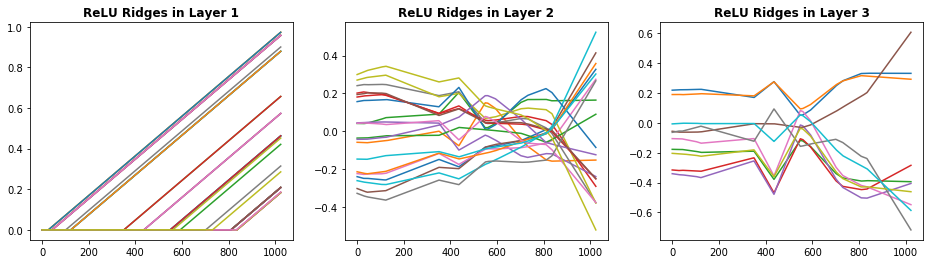

In [8]:
W1 = model.sess.run(model.W[0]); b1 = model.sess.run(model.b[0])
W2 = model.sess.run(model.W[1]); b2 = model.sess.run(model.b[1])
W3 = model.sess.run(model.W[2]); b3 = model.sess.run(model.b[2])

fig = plt.figure(figsize = (16, 4))
plt.subplot(1, 3, 1)
for j in range(W1.shape[1]):
    if (-b1[j]/W1[0,j]<1) and (-b1[j]/W1[0,j]>0):
        plt.plot(model.sess.run(model.h[1][:,j], feed_dict={model.X: train_x})) 
plt.title('ReLU Ridges in Layer 1', fontweight="bold")
  
plt.subplot(1, 3, 2)
for k in range(W2.shape[1]):
    plt.plot(model.sess.run(model.h[2][:,k], feed_dict={model.X: train_x}))
plt.title('ReLU Ridges in Layer 2', fontweight="bold")

plt.subplot(1, 3, 3)
for k in range(W3.shape[1]):
    plt.plot(model.sess.run(model.h[3][:,k], feed_dict={model.X: train_x}))
plt.title('ReLU Ridges in Layer 3', fontweight="bold")